## Analyzing Ocean Color Imagery

From September 26th cruise on the R/V Shearwater

All ocean color measurements taken using dual Micasense Altum/RedEdge rig

### Import Shearwater Data

Use pandas library to read the csv

In [9]:
import pandas as pd
df = pd.read_csv("data/260920_shearwateroffshore_dual/Shearwater 20200926/EventData/DataLogger/Data every 1 min_001.csv")
df.head()

,Date,Time,SW-ZDA-Year,SW-ZDA-Month,SW-ZDA-Day,SW-ZDA-Time,SW-GGA-Lat,SW-GGA-NorS,SW-GGA-Long,SW-GGA-EorW,...,SW-Weather-HumidRel-%,SW-Wind-WindSpeedRel,SW-Wind-WindAngleRel,TrueWind-DRV-SPEED,TrueWind-DRV-DIRECTION,TSG--temp-SBE38,TSG--sal,SW-Depth-DBT-Depth below transducer (m),DepthOverall-DRV-VALUE,Unnamed: 24
0,09/26/2020,12:41:07,2020,9,26,124231.70,3443.0547,N,7640.2337,W,...,83.3,9.39,153.99,9.29,168.89,22.4809,28.1481,5.21,6.21,NaN
1,09/26/2020,12:42:07,2020,9,26,124331.69,3443.0546,N,7640.2340,W,...,83.1,11.29,151.79,11.29,165.99,22.4674,28.1868,5.21,6.21,NaN
2,09/26/2020,12:43:07,2020,9,26,124433.00,3443.0546,N,7640.2347,W,...,83.0,9.49,136.79,8.40,147.89,22.4638,28.2144,5.21,6.21,NaN
3,09/26/2020,12:44:07,2020,9,26,124532.70,3443.0543,N,7640.2339,W,...,83.0,11.29,145.19,10.69,156.79,22.4665,28.2098,5.21,6.21,NaN
4,09/26/2020,12:45:07,2020,9,26,124632.70,3443.0541,N,7640.2339,W,...,83.1,12.38,148.20,12.40,162.39,22.4649,28.2215,5.21,6.21,NaN


Fix the date and time to be a python datetime object for easier plotting

In [10]:
from datetime import datetime

date_time_strs = df['Date'] + ' ' + df['Time']

df['datetime'] = [datetime.strptime(x, '%m/%d/%Y %H:%M:%S') for x in date_time_strs]

Convert the dms-ish format to decimal degrees

In [11]:
import numpy as np

def dms2dd(degrees, minutes, seconds, direction):
    dd = degrees + minutes/60 + seconds/(60*60);
    if direction == 'W' or direction == 'S':
        dd *= -1
    return dd;

df['lon'] = dms2dd(pd.to_numeric(df['SW-GGA-Long'].astype(str).str[:2]).astype(float), pd.to_numeric(df['SW-GGA-Long'].astype(str).str[2:]),np.array(0), 'W')
df['lat'] = dms2dd(pd.to_numeric(df['SW-GGA-Lat'].astype(str).str[:2]).astype(float), pd.to_numeric(df['SW-GGA-Lat'].astype(str).str[2:]),np.array(0), 'E')

Convert pandas dataframe to geodataframe with geospatial data incorporated

<AxesSubplot:>

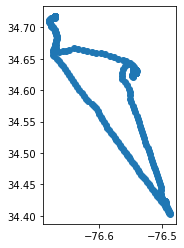

In [12]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon, df.lat))
gdf.plot()

It is coarse but let's plot it with coastline included from geopandas

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


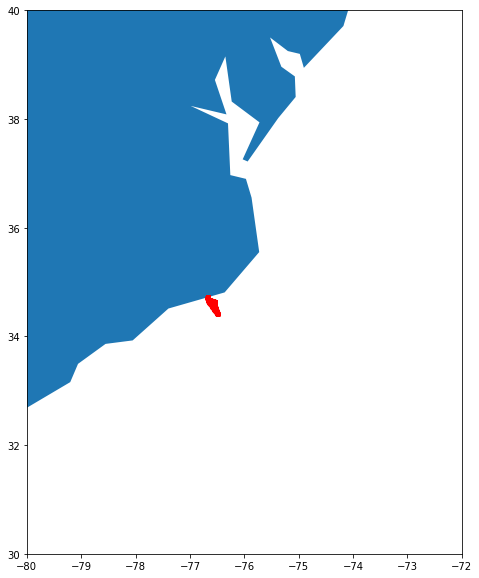

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(figsize=(10, 6), ax=ax)
gdf.plot(ax=ax, marker='o', color='red', markersize=15)

ax.set_xlim(-80, -72)
ax.set_ylim(30, 40)

fig.show()

<AxesSubplot:xlabel='lon', ylabel='lat'>

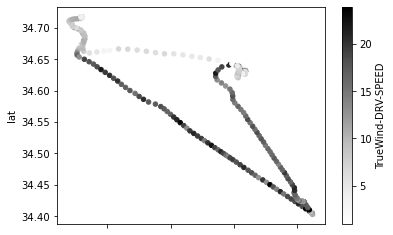

In [14]:
df.plot(kind='scatter',x='lon', y='lat', c='TrueWind-DRV-SPEED', cmap='Greys')

<AxesSubplot:xlabel='lon', ylabel='lat'>

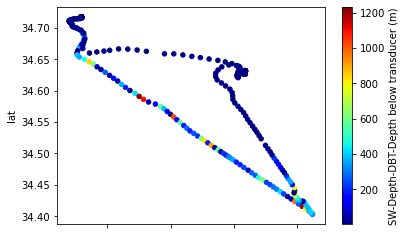

In [15]:
df.plot(kind='scatter',x='lon', y='lat', c='SW-Depth-DBT-Depth below transducer (m)', cmap='jet')

### UAS Ocean Color Data

Read in uas data which was saved as an ESRI shapefile that can be read with geopandas 

In [156]:
import geopandas as gpd
import pandas as pd
chla_gdf_dark = gpd.read_file('data/260920_shearwateroffshore_dual/uas_data_260920_1_dark.shp')
chla_gdf_dark.time = pd.to_datetime(chla_gdf_dark.time) # can't save shapefiles with datetime objects so just convert it back
chla_gdf_dark.spectra = chla_gdf_dark.spectra.apply(lambda x: x[1:-1].split(' ')) # can't save shapefiles with lists so just convert it back
print(len(chla_gdf_dark))
chla_gdf_dark.head()

62


,chla,Latitude,Longitude,spectra,time,geometry
0,9.299101,34.538931,-76.533789,"[, 0.00454497, , 0.00773598, , 0.00119302, , 0...",2020-09-26 15:42:41,POINT (-76.53379 34.53893)
1,6.485548,34.517408,-76.526608,"[, 5.31616539e-03, , 8.15064909e-03, , 1.25811...",2020-09-26 15:38:26,POINT (-76.52661 34.51741)
2,12.936102,34.602500,-76.553319,"[0.01170247, 0.02184923, 0.00660461, 0.0024286...",2020-09-26 15:54:35,POINT (-76.55332 34.60250)
3,6.325685,34.475156,-76.512294,"[, 0.00559642, , 0.00851711, , 0.00115089, , 0...",2020-09-26 15:29:51,POINT (-76.51229 34.47516)
4,12.927709,34.597997,-76.551900,"[0.00908497, 0.01695916, 0.00513756, 0.0019393...",2020-09-26 15:53:45,POINT (-76.55190 34.59800)


In [157]:
import geopandas as gpd
import pandas as pd
chla_gdf = gpd.read_file('data/260920_shearwateroffshore_dual/uas_data_260920_1.shp')
chla_gdf.time = pd.to_datetime(chla_gdf.time) # can't save shapefiles with datetime objects so just convert it back
chla_gdf.spectra = chla_gdf.spectra.apply(lambda x: x[1:-1].split(' ')) # can't save shapefiles with lists so just convert it back
print(len(chla_gdf))
chla_gdf.head()

100


,chla,Latitude,Longitude,spectra,time,geometry
0,9.299101,34.538931,-76.533789,"[, 0.00454497, , 0.00773598, , 0.00119302, , 0...",2020-09-26 15:42:41,POINT (-76.53379 34.53893)
1,6.485548,34.517408,-76.526608,"[, 5.31616539e-03, , 8.15064909e-03, , 1.25811...",2020-09-26 15:38:26,POINT (-76.52661 34.51741)
2,12.936102,34.602500,-76.553319,"[0.01170247, 0.02184923, 0.00660461, 0.0024286...",2020-09-26 15:54:35,POINT (-76.55332 34.60250)
3,14.799454,34.631789,-76.541047,"[0.01628596, 0.03155173, 0.01032061, 0.0050190...",2020-09-26 16:19:10,POINT (-76.54105 34.63179)
4,6.325685,34.475156,-76.512294,"[, 0.00559642, , 0.00851711, , 0.00115089, , 0...",2020-09-26 15:29:51,POINT (-76.51229 34.47516)


In [158]:
chla_gdf2 = gpd.read_file('data/260920_shearwateroffshore_dual/uas_data_260920_2.shp')
chla_gdf2.time = pd.to_datetime(chla_gdf2.time) # can't save shapefiles with datetime objects so just convert it back
chla_gdf2.spectra = chla_gdf2.spectra.apply(lambda x: x[1:-1].split(' ')) # can't save shapefiles with lists so just convert it back
print(len(chla_gdf2))
chla_gdf2.head()

100


,chla,Latitude,Longitude,spectra,time,geometry
0,5.336768,34.462406,-76.508372,"[6.30301264e-03, 9.11569927e-03, 1.32222296e-0...",2020-09-26 15:27:11,POINT (-76.50837 34.46241)
1,5.599160,34.515692,-76.526278,"[0.00640742, 0.00940206, 0.00198968, 0.0008567...",2020-09-26 15:38:06,POINT (-76.52628 34.51569)
2,6.695811,34.586894,-76.550833,"[0.01161248, 0.01797262, 0.00573639, 0.0026795...",2020-09-26 15:51:45,POINT (-76.55083 34.58689)
3,5.182080,34.525008,-76.528978,"[, 0.00598651, , 0.00858097, , 0.00131426, , 0...",2020-09-26 15:39:52,POINT (-76.52898 34.52501)
4,5.043906,34.462772,-76.508469,"[6.64787673e-03, 9.45079730e-03, 1.36946308e-0...",2020-09-26 15:27:16,POINT (-76.50847 34.46277)


In [159]:
chla_gdf3 = gpd.read_file('data/260920_shearwateroffshore_dual/uas_data_260920_3.shp')
chla_gdf3.time = pd.to_datetime(chla_gdf3.time) # can't save shapefiles with datetime objects so just convert it back
chla_gdf3.spectra = chla_gdf3.spectra.apply(lambda x: x[1:-1].split(' ')) # can't save shapefiles with lists so just convert it back
print(len(chla_gdf3))
chla_gdf3.head()

100


,chla,Latitude,Longitude,spectra,time,geometry
0,10.097996,34.622675,-76.564558,"[0.00826107, 0.01439348, 0.00347201, 0.0014965...",2020-09-26 15:58:35,POINT (-76.56456 34.62268)
1,8.552395,34.539731,-76.534089,"[, 0.00477034, , 0.00792764, , 0.0013452, , , ...",2020-09-26 15:42:51,POINT (-76.53409 34.53973)
2,5.592785,34.500703,-76.521011,"[, 0.00565574, , 0.00829622, , 0.00108171, , 0...",2020-09-26 15:35:11,POINT (-76.52101 34.50070)
3,8.325213,34.473831,-76.511914,"[5.12945398e-03, 8.45873695e-03, 1.33374694e-0...",2020-09-26 15:29:36,POINT (-76.51191 34.47383)
4,10.376169,34.553928,-76.539181,"[, 0.00535169, , 0.00939612, , 0.00148981, , 0...",2020-09-26 15:45:31,POINT (-76.53918 34.55393)


In [160]:
chla_gdf4 = gpd.read_file('data/260920_shearwateroffshore_dual/uas_data_260920_4.shp')
chla_gdf4.time = pd.to_datetime(chla_gdf4.time) # can't save shapefiles with datetime objects so just convert it back
chla_gdf4.spectra = chla_gdf4.spectra.apply(lambda x: x[1:-1].split(' ')) # can't save shapefiles with lists so just convert it back
print(len(chla_gdf4))
chla_gdf4.head()

100


,chla,Latitude,Longitude,spectra,time,geometry
0,7.308460,34.626342,-76.564711,"[0.00975423, 0.01548933, 0.00367371, 0.0016682...",2020-09-26 15:59:15,POINT (-76.56471 34.62634)
1,8.625780,34.624425,-76.564583,"[0.00922692, 0.0153715, , 0.00349896, 0.001458...",2020-09-26 15:58:55,POINT (-76.56458 34.62443)
2,12.893406,34.631675,-76.541072,"[0.01752534, 0.03269103, 0.01183231, 0.0070138...",2020-09-26 16:22:45,POINT (-76.54107 34.63168)
3,4.772757,34.460547,-76.507719,"[, 0.00622324, , 0.00869858, , 0.00103453, , 0...",2020-09-26 15:26:47,POINT (-76.50772 34.46055)
4,9.818015,34.640911,-76.554472,"[0.01563171, 0.02701992, 0.00901498, 0.0043374...",2020-09-26 16:02:30,POINT (-76.55447 34.64091)


In [161]:
chla_gdf = chla_gdf.append(chla_gdf2, ignore_index=True)
chla_gdf = chla_gdf.append(chla_gdf3, ignore_index=True)
chla_gdf = chla_gdf.append(chla_gdf4, ignore_index=True)
print(len(chla_gdf))

400


In [162]:
print(len(chla_gdf))

400


In [141]:
# chla_gdf.time = chla_gdf.time.astype(str)
# chla_gdf.spectra = chla_gdf.spectra.astype(str)
# chla_gdf.to_file('data/260920_shearwateroffshore_dual/uas_data_260920_full.shp')

In [108]:
sw_chla_gdf = gpd.read_file('uas_data_0005.shp')
sw_chla_gdf.time = pd.to_datetime(sw_chla_gdf.time) # can't save shapefiles with datetime objects so just convert it back
sw_chla_gdf.spectra = sw_chla_gdf.spectra.apply(lambda x: x[1:-1].split(' ')) # can't save shapefiles with lists so just convert it back
sw_chla_gdf.head()

,chla,Latitude,Longitude,spectra,time,geometry
0,6.099412,34.586856,-76.555336,"[0.02999167, 0.04515203, 0.01194982, 0.0050126...",2020-09-13 14:09:19,POINT (-76.55534 34.58686)
1,7.363885,34.585728,-76.554025,"[0.04894378, 0.07789224, 0.04111039, 0.0312854...",2020-09-13 14:11:12,POINT (-76.55402 34.58573)
2,6.587307,34.585536,-76.553925,"[0.05387808, 0.08298596, 0.04735034, 0.0370990...",2020-09-13 14:11:20,POINT (-76.55392 34.58554)
3,11.328415,34.586717,-76.555253,"[0.02141596, 0.03853804, 0.01059423, 0.0032117...",2020-09-13 14:09:33,POINT (-76.55525 34.58672)
4,5.388796,34.586628,-76.555203,"[0.03152826, 0.04573177, 0.0150598, , 0.009890...",2020-09-13 14:09:42,POINT (-76.55520 34.58663)


<AxesSubplot:>

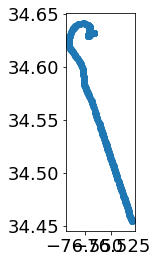

In [109]:
chla_gdf.plot()

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


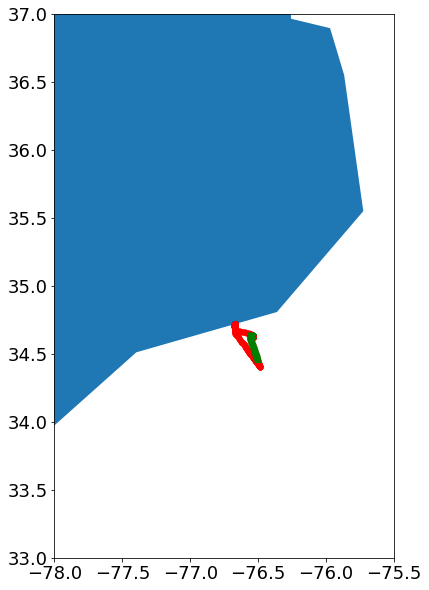

In [110]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(figsize=(10, 6), ax=ax)
gdf.plot(ax=ax, marker='o', color='red', markersize=25)
chla_gdf.plot(ax=ax, marker='x', color='green', markersize=20)

ax.set_xlim(-78, -75.5)
ax.set_ylim(33, 37)

fig.show()

Text(0.5, 0, 'Time')

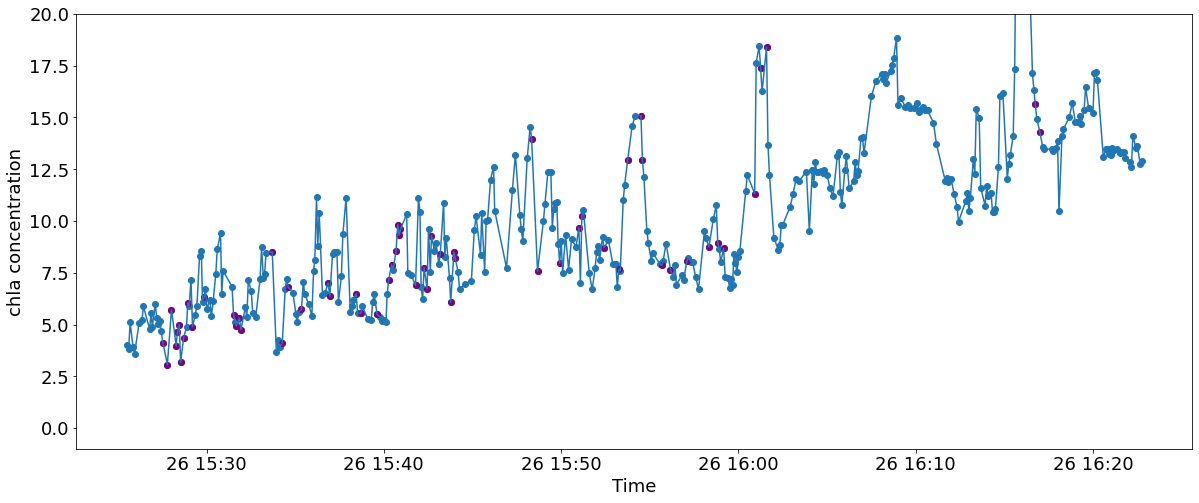

In [112]:
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(figsize=(20, 8))

ax.scatter(chla_gdf.time, chla_gdf.chla)
ax.plot(chla_gdf.sort_values(by='time').time, chla_gdf.sort_values(by='time').chla)
ax.scatter(chla_gdf_dark.time, chla_gdf_dark.chla, color='purple')
ax.set_ylim(-1,20)
ax.set_ylabel('chla concentration')
ax.set_xlabel('Time')
#ax.set_yscale('log')
#plt.savefig('chlaall.png')

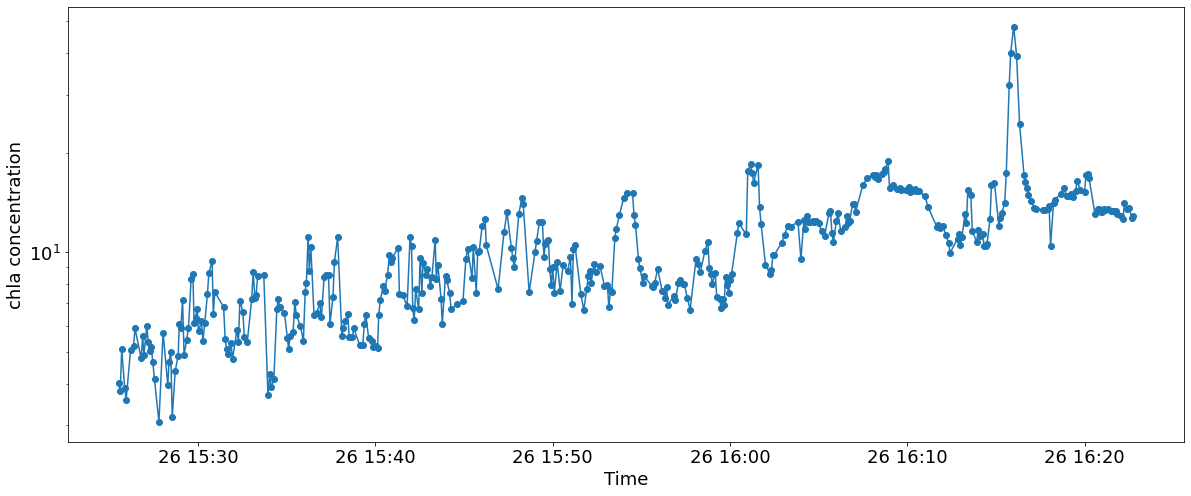

In [97]:
fig, ax = plt.subplots(figsize=(20, 8))

#ax.set_xlim(datetime.strptime('2020-09-13 15:10:46', '%Y-%m-%d %H:%M:%S'), datetime.strptime('2020-09-13 16:50:46', '%Y-%m-%d %H:%M:%S'))


ax.scatter(chla_gdf.time, chla_gdf.chla)
ax.plot(chla_gdf.sort_values(by='time').time, chla_gdf.sort_values(by='time').chla)
#ax.set_ylim(-1,12)
ax.set_ylabel('chla concentration')
ax.set_xlabel('Time')
ax.set_yscale('log')

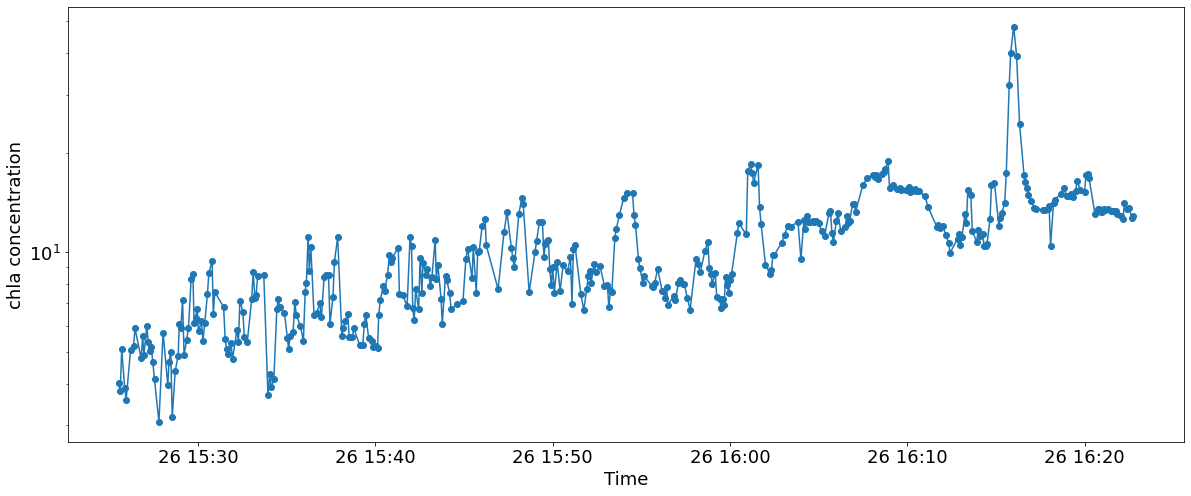

In [163]:
fig, ax = plt.subplots(figsize=(20, 8))

#ax.set_xlim(datetime.strptime('2020-09-13 15:10:46', '%Y-%m-%d %H:%M:%S'), datetime.strptime('2020-09-13 16:50:46', '%Y-%m-%d %H:%M:%S'))


ax.scatter(chla_gdf.time, chla_gdf.chla)
ax.plot(chla_gdf.sort_values(by='time').time, chla_gdf.sort_values(by='time').chla)
#ax.set_ylim(-1,12)
ax.set_ylabel('chla concentration')
ax.set_xlabel('Time')
ax.set_yscale('log')

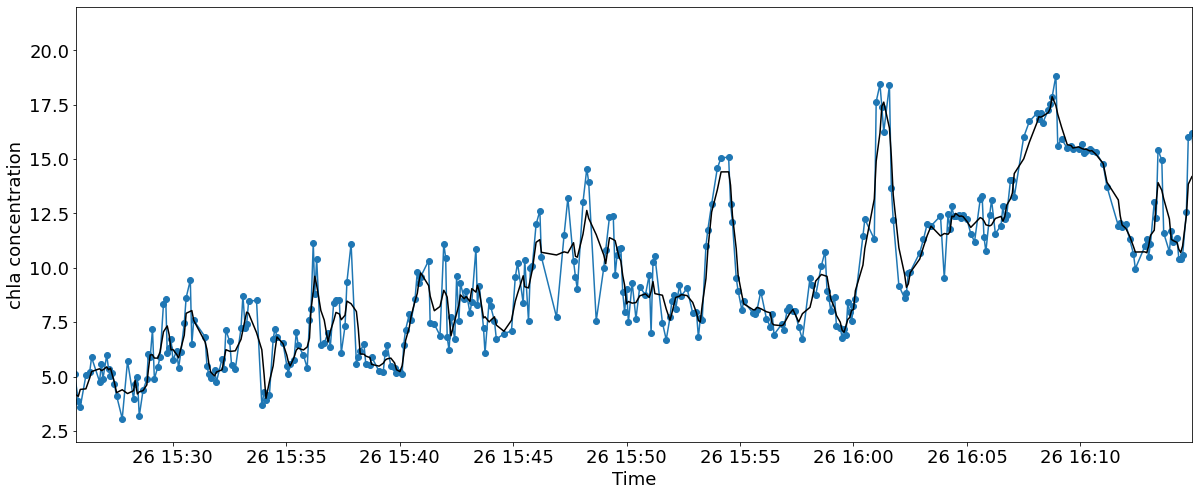

In [171]:
fig, ax = plt.subplots(figsize=(20, 8))

ax.scatter(chla_gdf.time, chla_gdf.chla)
ax.plot(chla_gdf.sort_values(by='time').time, chla_gdf.sort_values(by='time').chla)
ax.plot(chla_gdf.sort_values(by='time').time, chla_gdf.sort_values(by='time').chla.rolling(window=4, center=True).mean(), color='black')
ax.set_ylim(2,22)
ax.set_ylabel('chla concentration')
ax.set_xlim(datetime.strptime('2020-09-26 15:25:46', '%Y-%m-%d %H:%M:%S'), datetime.strptime('2020-09-26 16:14:56', '%Y-%m-%d %H:%M:%S'))
ax.set_xlabel('Time')
#ax.set_yscale('log')
plt.savefig('chl_timeline.png',dpi=300)

In [142]:
df.rolling(window=5).mean()

fig, ax = plt.subplots(figsize=(20, 8))

#ax.set_xlim(datetime.strptime('2020-09-13 16:30:46', '%Y-%m-%d %H:%M:%S'), datetime.strptime('2020-09-13 16:45:46', '%Y-%m-%d %H:%M:%S'))


ax.scatter(chla_gdf.time, chla_gdf.chla)
ax.plot(chla_gdf.sort_values(by='time').time, chla_gdf.sort_values(by='time').chla)
#ax.plot(chla_gdf.sort_values(by='time').time, chla_gdf.sort_values(by='time').chla.rolling(window=5).mean())
ax.set_ylim(0.04,0.12)
ax.set_ylabel('chla concentration')
ax.set_xlabel('Time')
#ax.set_yscale('log')
#plt.savefig('chlzoom.png')

IndexError: list assignment index out of range

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


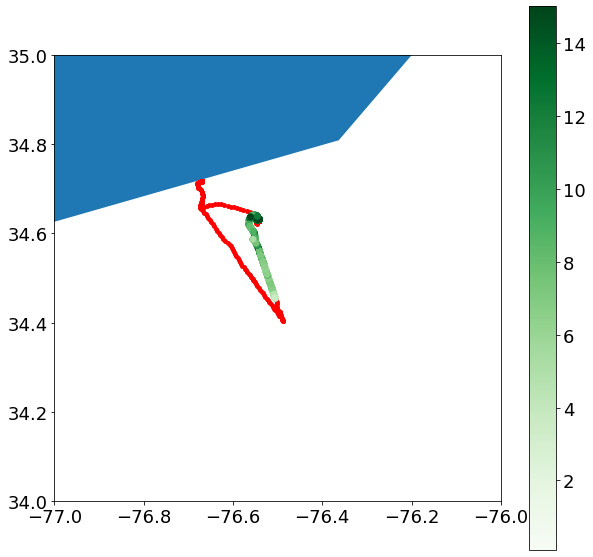

In [125]:
fig, ax = plt.subplots(figsize=(10, 10))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(figsize=(10, 6), ax=ax)
gdf.plot(ax=ax, marker='o', color='red', markersize=15)

ax.set_xlim(-77, -76)
ax.set_ylim(34, 35)


sc = ax.scatter(chla_gdf.Longitude, chla_gdf.Latitude, c=chla_gdf.chla, cmap='Greens',vmin=0.1, vmax=15)

ax.scatter(sw_chla_gdf.Longitude, sw_chla_gdf.Latitude, c=sw_chla_gdf.chla, cmap='Greens',vmin=0.1, vmax=15)

fig.colorbar(sc)
fig.show()

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  after removing the cwd from sys.path.
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


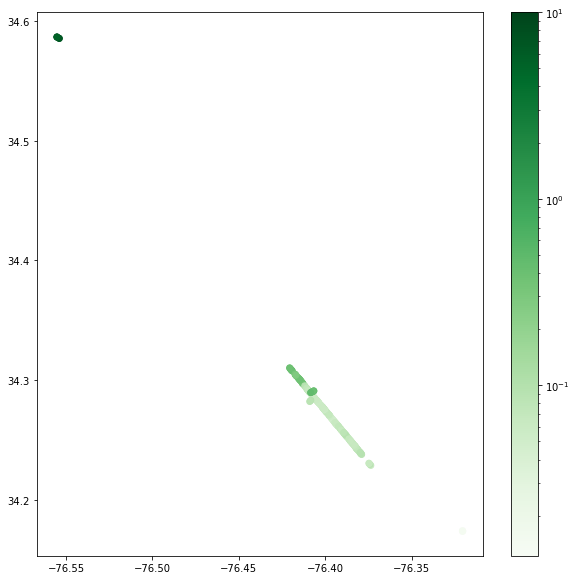

In [91]:
import matplotlib
fig, ax = plt.subplots(figsize=(10, 10))

sc = ax.scatter(chla_gdf.Longitude, chla_gdf.Latitude, c=chla_gdf.chla, cmap='Greens', vmax=10, norm=matplotlib.colors.LogNorm())
fig.colorbar(sc)
fig.show()

### Plot them together

<AxesSubplot:>

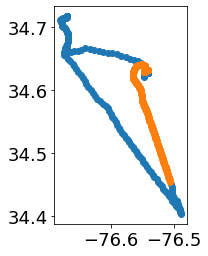

In [113]:
fig, ax = plt.subplots()

gdf.plot(ax=ax)
chla_gdf.plot(ax=ax)

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


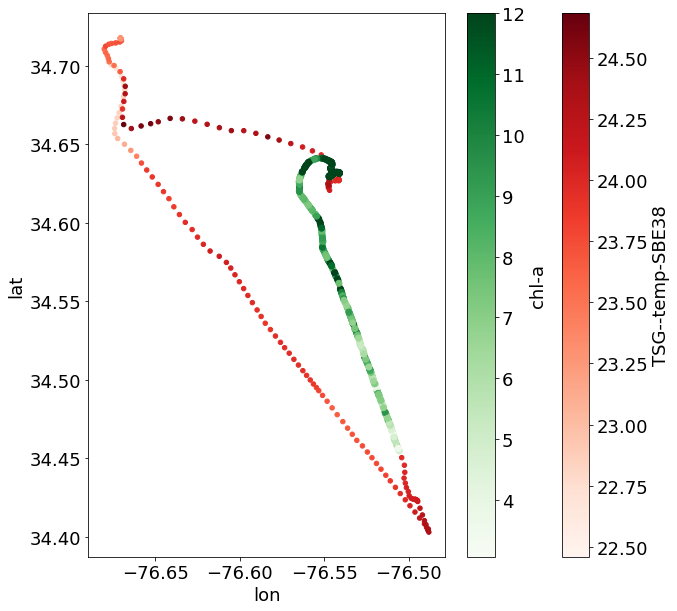

In [151]:
fig, ax = plt.subplots(figsize=(10,10))
df.plot(kind='scatter',x='lon', y='lat', c='TSG--temp-SBE38', cmap='Reds',ax=ax)
im = ax.scatter(chla_gdf.Longitude, chla_gdf.Latitude, c=chla_gdf.chla, cmap='Greens', vmax=12)
fig.colorbar(im, label='chl-a')
plt.savefig('chla_fig.png',dpi=300)
fig.show()

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


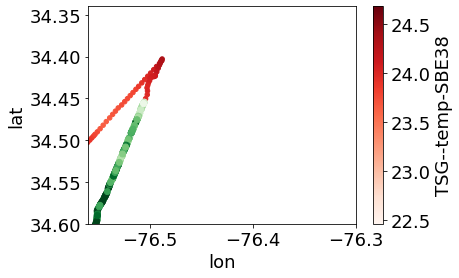

In [121]:
fig, ax = plt.subplots()
df.plot(kind='scatter',x='lon', y='lat', c='TSG--temp-SBE38', cmap='Reds',ax=ax)
ax.scatter(chla_gdf.Longitude, chla_gdf.Latitude, c=chla_gdf.chla, cmap='Greens', vmax=10)
ax.set_ylim(34.1,34.35)
ax.set_xlim(-76.5.6,-76.30)
fig.show()

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


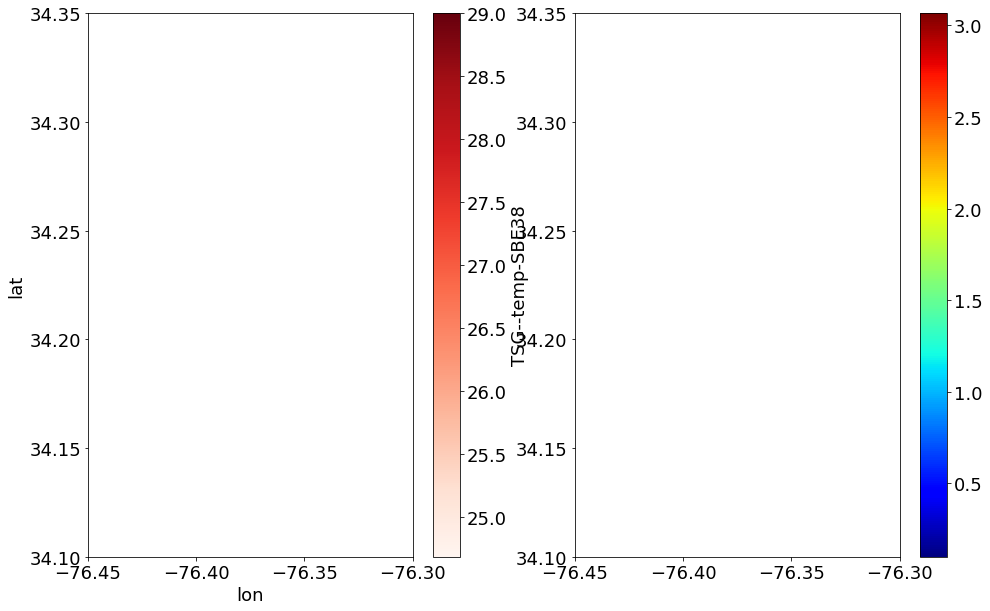

In [118]:
fig, ax = plt.subplots(1,2, figsize=(16,10))
df.plot(kind='scatter',x='lon', y='lat', c='TSG--temp-SBE38', cmap='Reds',ax=ax[0], vmin=29)
sc = ax[1].scatter(chla_gdf.Longitude, chla_gdf.Latitude, c=chla_gdf.chla, cmap='jet', vmax=0.1)
fig.colorbar(sc)
ax[0].set_ylim(34.1,34.35)
ax[0].set_xlim(-76.45,-76.30)
ax[1].set_ylim(34.1,34.35)
ax[1].set_xlim(-76.45,-76.30)
plt.savefig('chlvssst.png')
fig.show()

#### Plot chl-a against S and T from the Shearwater

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


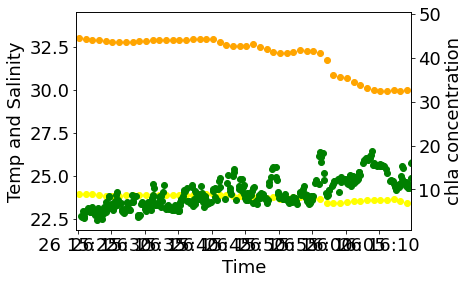

In [140]:
fig, ax = plt.subplots()

ax.set_xlim(datetime.strptime('2020-09-26 15:24:46', '%Y-%m-%d %H:%M:%S'), datetime.strptime('2020-09-26 16:14:46', '%Y-%m-%d %H:%M:%S'))

ax2 = ax.twinx()
ax.set_ylabel('Temp and Salinity')
ax.set_xlabel('Time')
ax2.set_ylabel('chla concentration')
ax.scatter(x=gdf['datetime'], y=gdf['TSG--temp-SBE38'], color='yellow')
ax.scatter(x=gdf['datetime'], y=gdf['TSG--sal'], color='orange')
ax2.scatter(x=chla_gdf['time'], y=chla_gdf['chla'], color='green')
fig.show()


/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


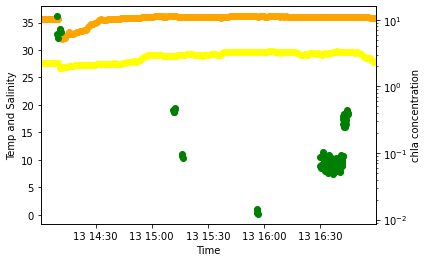

In [99]:
fig, ax = plt.subplots()

ax.set_xlim(datetime.strptime('2020-09-13 14:00:46', '%Y-%m-%d %H:%M:%S'), datetime.strptime('2020-09-13 16:59:46', '%Y-%m-%d %H:%M:%S'))

ax2 = ax.twinx()
ax.set_ylabel('Temp and Salinity')
ax.set_xlabel('Time')
ax2.set_ylabel('chla concentration')
ax2.set_yscale('log')
ax.scatter(x=gdf['datetime'], y=gdf['TSG--temp-SBE38'], color='yellow')
ax.scatter(x=gdf['datetime'], y=gdf['TSG--sal'], color='orange')
ax2.scatter(x=chla_gdf['time'], y=chla_gdf['chla'], color='green')
fig.show()


In [192]:
chla_gdf.spectra.values

array([list(['0.02200393', '0.00789785', '0.00113606', '0.00078107', '0.00072814']),
       list(['0.02668011', '0.01040405', '0.00151097', '0.00121781', '0.00146622']),
       list(['0.03596776', '0.01744403', '0.00180694', '0.00118068', '0.0013282', '']),
       list(['0.02093576', '0.00810775', '0.00116406', '0.00089808', '0.00116452']),
       list(['0.03313249', '0.01624155', '0.00177827', '0.00108651', '0.00120601']),
       list(['0.03258913', '0.01424824', '0.00167678', '0.00116578', '0.00147281']),
       list(['0.01953409', '0.0067388', '', '0.0008794', '', '0.00065381', '0.00088336']),
       list(['0.03147974', '0.01532142', '0.00186861', '0.00116014', '0.00122541']),
       list(['0.02872116', '0.01115625', '0.001361', '', '', '0.00098762', '0.00122088']),
       list(['0.02812097', '0.01093312', '0.00132842', '0.00094661', '0.00118423']),
       list(['0.02496985', '0.00888755', '0.00081982', '0.00063116', '0.00086274']),
       list(['0.03102751', '0.01291972', '0.001901

In [194]:
spectra = []
for strl in chla_gdf.spectra.values:
    spec = []
    for i in strl:
        if i != '':
            spec.append(float(i))
    spectra.append(spec)
np.array(spectra).shape

(200, 5)

In [195]:
spectra = np.array(spectra)

### Clustering Spectra

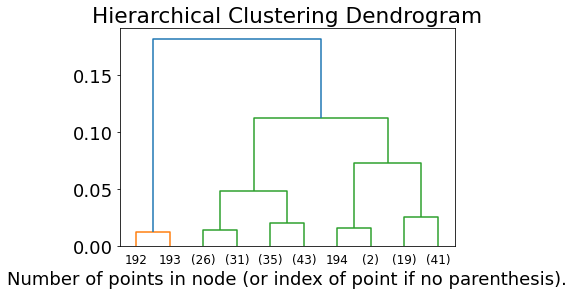

In [217]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(spectra)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [236]:
model = AgglomerativeClustering(n_clusters=4).fit(spectra)

In [237]:
np.unique(model.labels_, return_counts=True)


(array([0, 1, 2, 3]), array([135,   3,  60,   2]))

In [238]:
colors = []
for lab in model.labels_:
    if lab == 0:
        colors.append('red')
    elif lab == 1:
        colors.append('green')
    elif lab == 2:
        colors.append('blue')
    elif lab == 3:
        colors.append('black')
    elif lab == 4:
        colors.append('purple')

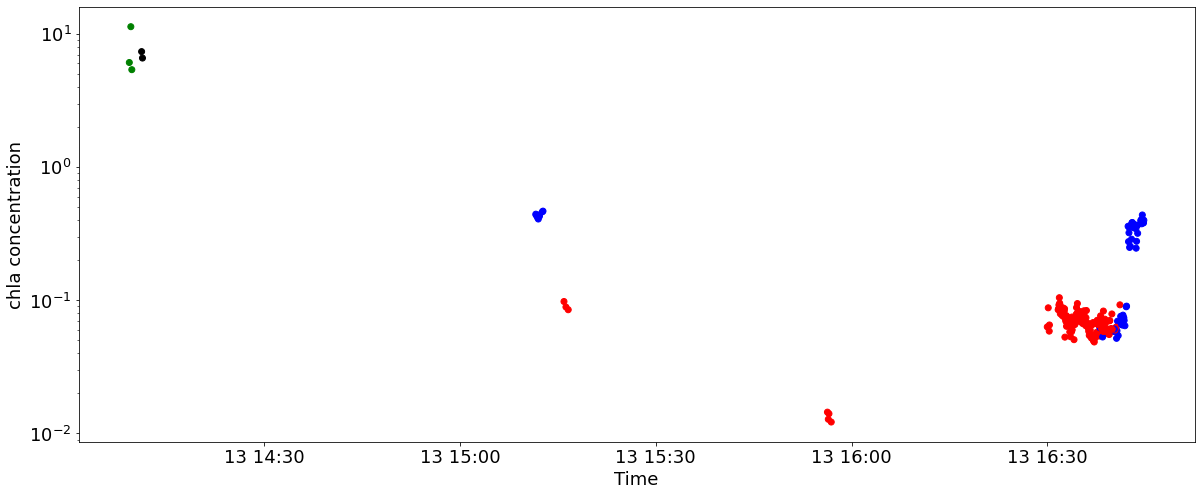

In [239]:
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(figsize=(20, 8))

ax.scatter(chla_gdf.time, chla_gdf.chla, color=colors)
#ax.plot(chla_gdf.sort_values(by='time').time, chla_gdf.sort_values(by='time').chla)
#ax.set_ylim(-1,12)
ax.set_ylabel('chla concentration')
ax.set_xlabel('Time')
ax.set_yscale('log')

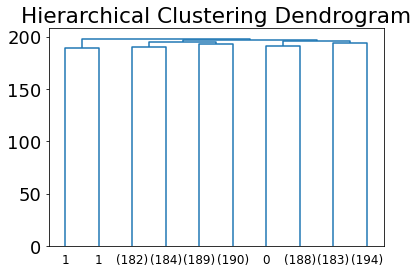

In [257]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering
ddr = None
def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, truncate_mode='level', p=3, **kwargs)


iris = load_iris()
x = iris.data[:20]
model = AgglomerativeClustering(n_clusters=3)

model = model.fit(spectra)
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, labels=model.labels_)
plt.show()

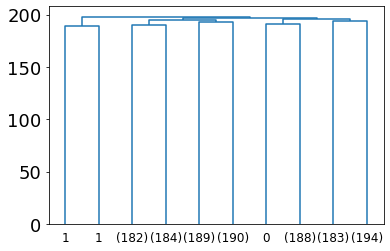

In [256]:
# Children of hierarchical clustering
children = model.children_

# Distances between each pair of children
# Since we don't have this information, we can use a uniform one for plotting
distance = np.arange(children.shape[0])

# The number of observations contained in each cluster level
no_of_observations = np.arange(2, children.shape[0]+2)

# Create linkage matrix and then plot the dendrogram
linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

# Plot the corresponding dendrogram
ddr = dendrogram(linkage_matrix, labels=model.labels_, truncate_mode='level', p=3)

In [252]:
ddr.keys()

dict_keys(['icoord', 'dcoord', 'ivl', 'leaves', 'color_list'])